# Exploration  

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from cdlib import viz
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import networkx as nx
#from pyvis import network as net
from cdlib import algorithms, viz
from difflib import get_close_matches
from collections import Counter
from difflib import SequenceMatcher


from statsmodels.stats import diagnostic
from scipy import stats

## Loading CSV files for data story

In [103]:
all_movies = pd.read_csv("./CSV_files/all_movies_metadata.csv")
movie_table = pd.read_csv("./CSV_files/movies_communities_table_scraping_done.csv")
data_movies = pd.read_csv("./CSV_files/movies_communities_metadata_scraping_done.csv")
data_actors = pd.read_csv("./CSV_files/top_20_communities_scraping_done.csv")
community_sizes = pd.read_csv('./CSV_files/community_sizes.csv')
relationships = pd.read_csv('./CSV_files/inter-communities-caracteristics.csv')
features = pd.read_csv('./CSV_files/communities_features.csv')
features_movies = pd.read_csv('./CSV_files/communities_movies_top_features.csv')
features_movies_full = pd.read_csv('./CSV_files/communities_movies_full_features.csv')

### Formatting the CSV file

In [104]:
data_movies.drop(['Unnamed: 0'],axis=1,inplace=True)
relationships.drop('Unnamed: 0',axis = 1,inplace = True)

In [105]:
# function that converts the string to a dictionary
def convert_to_dict(string):
    if isinstance(string, str):
        if string == '{}':
            return {}
        else:
            string = string.replace('{', '').replace('}', '').replace('"', '').replace("'",'')
            string = string.split(',')
            string = [x.split(':') for x in string]
            dictionnary = {x[0].strip(): x[1].strip() for x in string}
            return dictionnary

# function that converts the string to a list
def clean_dict(elt):
    if ':' in elt:
        elt = elt[elt.index(':') + 1 : ]
    elt = elt.strip()
    return elt

def convert_to_list(cell):
    if isinstance(cell, str):
        if cell == '{}':
            return []
        if cell == '[]':
            return []
        else:
            cell = cell.replace('[', '').replace(']', '').replace('"', '').replace("'",'')
            cell = cell.replace('{', '').replace('}', '')
            cell = cell.split(',')
            cell = [clean_dict(x) for x in cell]
            return cell


In [106]:
# apply the function to the genres column
data_movies['Movie_genres'] = data_movies['Movie_genres'].apply(convert_to_list)
# apply the same function as Movies_genre to the countries column
data_movies['Movie_countries'] = data_movies['Movie_countries'].apply(convert_to_list)

# apply the function to the language column
data_movies['Movie_languages'] = data_movies['Movie_languages'].apply(convert_to_list)


# apply the function to the genres column
all_movies['Movie_genres'] = all_movies['Movie_genres'].apply(convert_to_list)
# apply the same function as Movies_genre to the countries column
all_movies['Movie_countries'] = all_movies['Movie_countries'].apply(convert_to_list)

# apply the function to the language column
all_movies['Movie_languages'] = all_movies['Movie_languages'].apply(convert_to_list)

In [107]:
for i in range(1,21):
    vars()['datamov' + str(i)]= data_movies[~(data_movies[str(i)] == 0)]

### Dataset of actors merging with actor_metadata (to be removed once properly done)

In [108]:
data_actors = pd.read_csv("./CSV_files/top_20_communities_scraping_done.csv")

In [109]:
character_metadata = pd.read_csv(
    'MovieSummaries/character.metadata.tsv', sep='\t', header=None)
character_metadata.columns = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Character_name', 'Actor_date_of_birth', 'actor_gender',
                              'Actor_height_(in_meters)', 'Actor_ethnicity', 'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character/actor_map_ID', 'Freebase_character_ID', 'Freebase_actor_ID']


In [110]:
character_metadata.drop_duplicates(subset=['Freebase_actor_ID'],inplace=True)
data_actors = data_actors.merge(character_metadata,left_on='Freebase_actor_ID',right_on='Freebase_actor_ID')
data_actors.drop(['Actor_ethnicity','Freebase_character/actor_map_ID','Freebase_character_ID','Actor_height_(in_meters)',
                    'Character_name','Actor_age_at_movie_release','Wikipedia_movie_ID','Freebase_movie_ID','Movie_release_date'],axis = 1 ,inplace = True)

## Distribution of community sizes

In [71]:
nb_actors_20 = []
for com in range(1,21):
    nb_actors_20.append(len(data_actors[(data_actors['Community'] == com)]))

In [72]:
for i in range(20):
    community_sizes['size'][i]= nb_actors_20[i]

In [73]:
#df = px.data.com_sizes() # iris is a pandas DataFrame
fig = px.scatter(community_sizes, x='community',y='size',
                    title='Number of actors by community',log_x=True,log_y=True,labels=('Community label','Number of actors'),
                    template= 'plotly_white',color_discrete_sequence=['darkblue'])
fig.show()
fig.write_html('C:/Users/Public/ADA2022/weloic.github.io/_includes/community_sizes_scatter.html')

## Number of movies by communities

In [74]:
nb_movie = []
for com in range(1,21):
    nb_movie.append(len(data_movies[~(data_movies[str(com)] == 0)]))

In [75]:
abs_trace = go.Scatter(mode="lines+markers", x=[*range(1,21)],y=nb_movie,marker = {'size':10,'color':'blue'},line={'width':2,'dash':'dot'})
ratio_trace = go.Scatter(mode="lines+markers", x=[*range(1,21)],y=[i / j for i, j in zip(nb_movie, nb_actors_20)], 
                        marker = {'size':6,'color':'gold','symbol':'x'},line={'width':1,'dash':'dot'})

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(ratio_trace,secondary_y= True)
fig.add_trace(abs_trace)

fig.update_layout( title_text="Movies by community",template = 'plotly_white')
fig.update_layout(yaxis=dict(title="Movies number", titlefont=dict(color="blue"), tickfont=dict(color="blue")),
                    yaxis2=dict(title="Average movies by actor",overlaying="y", side="right", titlefont=dict(color="gold"),position=0.15,tickfont=dict(color="gold")),
                    showlegend = False)

fig.show()
fig.write_html('C:/Users/Public/ADA2022/weloic.github.io/_includes/movies_community_scatter.html')

## Community features

In [77]:
# each country gets its own trace so that it will have a different color
c1 = features.pivot_table(index='Community',columns='1st_country',values='1st_country_%').fillna(0)
c2 = features.pivot_table(index='Community',columns='2nd_country',values='2nd_country_%').fillna(0)
c3 = features.pivot_table(index='Community',columns='3rd_country',values='3rd_country_%').fillna(0)
countries = c2.add(c1,fill_value=0).add(c3,fill_value=0)
countries.drop('0',axis=1,inplace=True)
countries['Others'] = countries.apply(lambda x: 100 - sum(x),axis=1)

In [78]:
# each occupation gets its own trace so that it will have a different color
o1 = features.pivot_table(index='Community',columns='1st_occupation',values='1st_occupation_%').fillna(0)
o2 = features.pivot_table(index='Community',columns='2nd_occupation',values='2nd_occupation_%').fillna(0)
o3 = features.pivot_table(index='Community',columns='3rd_occupation',values='3rd_occupation_%').fillna(0)
occupations = o2.add(o1,fill_value=0).add(o3,fill_value=0)
occupations['Others'] = occupations.apply(lambda x: 100 - sum(x),axis=1)

In [79]:
countries.columns

Index(['Australia', 'Bhutan', 'Canada', 'China', 'Egypt', 'France', 'Germany',
       'Hong Kong', 'India', 'Ireland', 'Italy', 'Japan', 'Netherlands',
       'Pakistan', 'Portugal', 'Spain', 'Sweden', 'Taiwan', 'United Kingdom',
       'United States of America', 'Others'],
      dtype='object')

In [80]:
# color dictionnary for the interactive plot
# colors are grouped by continent 
color_dict={
    'female_%':'orange',
    'male_%':'red',

    'Others' : 'beige',

    'Australia' : 'red',
    'United States of America' : 'firebrick',
    'United Kingdom': 'indianred' ,
    'Canada': 'darkred',
    
    'India' : 'orange',
    'Bhutan' : 'orangered',
    'Pakistan': 'coral',

    'China' : 'green',
    'Japan' : 'seagreen',
    'Taiwan' : 'lime',
    'Hong Kong' : 'forestgreen',

    'Egypt' : 'gold',

    'Ireland': '#264653', 
    'Italy' : '#298880', #Celadon green
    'France': '#287271', #Skobeloff
    'Germany':'steelblue',
    'Netherlands': 'navy',
    'Portugal' : 'navy',
    'Spain': 'navy',
    'Sweden' : '#264653' #charcoal 


}

In [81]:
fig = make_subplots(rows=1, cols=3,shared_yaxes=True,subplot_titles=('Gender (%)','Nationality  (%)','Occupation (%)'))

fig.add_trace(go.Bar( x=features['Males_%'], y=features['Community'],orientation='h',name = 'male',marker={'color':color_dict['male_%']}),
                row=1, col=1
)
fig.add_trace(go.Bar( x=features['Females_%'], y=features['Community'],orientation='h',name = 'female',marker={'color':color_dict['female_%']}),
                row=1, col=1
)

#Country column
for label in countries.columns:
    fig.add_trace(
        go.Bar( x=countries[label], y=countries.index,orientation='h',name = label,marker={'color':color_dict[label]}),
        row=1, col=2
    )

# Occupation column
for label in occupations.columns:
    fig.add_trace(
        go.Bar( x=occupations[label], y=occupations.index,orientation='h',name = label),
        row=1, col=3
    )

fig.update_layout(height = 600, title_text="The 20 biggest communities distribution of features")
fig.update_layout(barmode = 'stack')
fig['layout']['yaxis']['autorange'] = "reversed"

fig.show()
fig.write_html('C:/Users/Public/ADA2022/weloic.github.io/_includes/top20_characterisation.html')

## Interelationship

In [82]:
relationship = pd.read_csv('./CSV_files/inter-communities-caracteristics.csv')
relationship.drop('Unnamed: 0',axis = 1,inplace = True)

<AxesSubplot:xlabel='Community_2', ylabel='Community_1'>

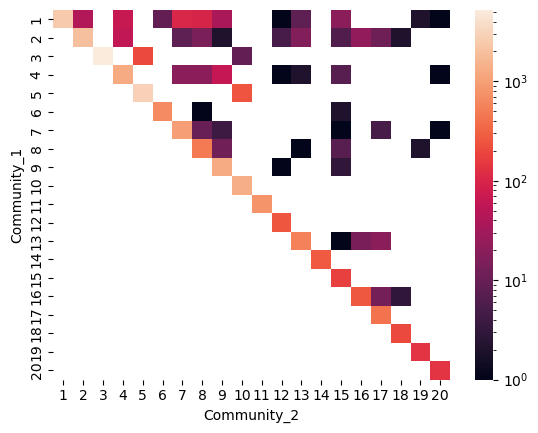

In [83]:
relation_matrix = relationship.pivot_table(index='Community_1',columns='Community_2',values='count')
sns.heatmap(relation_matrix,norm = LogNorm())

## India

In [121]:
fig = go.Figure()

fig.add_trace(go.Box(x = datamov3.Movie_release_year,name = '3'))
fig.add_trace(go.Box(x = datamov5.Movie_release_year,name = '5'))
fig.add_trace(go.Box(x = datamov10.Movie_release_year,name = '10'))

fig.update_layout(title = 'Distribution of movies over time for the Indian communities',template = 'plotly_white')
fig.update_xaxes(title = 'years')
fig.update_yaxes(title = 'community')
fig.show()

fig.write_html('C:/Users/Public/ADA2022/weloic.github.io/_includes/india_time.html')

In [85]:
print(stats.ttest_ind(datamov3.Movie_release_year.dropna(),datamov5.Movie_release_year.dropna()))
print(stats.ttest_ind(datamov10.Movie_release_year.dropna(),datamov5.Movie_release_year.dropna()))
print(stats.ttest_ind(datamov3.Movie_release_year.dropna(),datamov10.Movie_release_year.dropna()))

Ttest_indResult(statistic=-6.062525433826842, pvalue=1.4108695631365665e-09)
Ttest_indResult(statistic=9.283480718604071, pvalue=2.4365309232416955e-20)
Ttest_indResult(statistic=-15.074374794060214, pvalue=2.5498741497399483e-50)


[('Drama', 2335), ('World cinema', 1558), ('Romance Film', 1132), ('Bollywood', 1077), ('Action', 861), ('Musical', 858), ('Romantic drama', 574)]
[('Drama', 1773), ('Romance Film', 757), ('Action', 717), ('World cinema', 620), ('Musical', 444), ('Comedy', 346), ('Bollywood', 338)]
[('Drama', 957), ('Action', 388), ('Romance Film', 289), ('Comedy', 237), ('Thriller', 218), ('World cinema', 171), ('Musical', 164)]


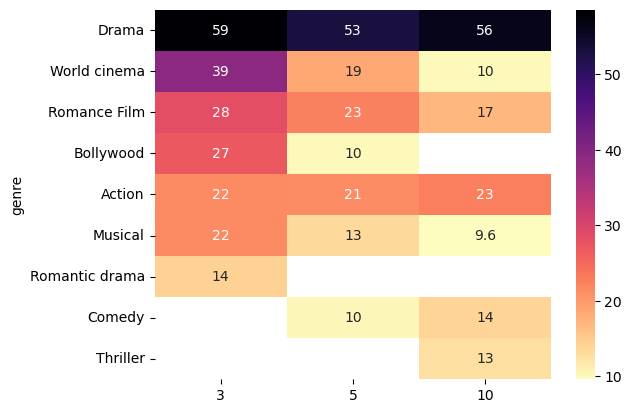

In [128]:
n = 7

first_genres = pd.DataFrame(columns=['genre'])
for i in [3,5,10]:
    genres = Counter([x for y in vars()['datamov' + str(i)]['Movie_genres'].values for x in y]).most_common(n)
    print(genres)
    genres = pd.DataFrame(data=genres, columns=['genre',str(i)])
    first_genres = first_genres.merge(genres,how='outer',on='genre')
    normalization = len(vars()['datamov' + str(i)])
    first_genres[str(i)]= first_genres[str(i)].apply(lambda x : x/normalization*100)

first_genres.set_index(['genre'],inplace = True)
plot = sns.heatmap(data=first_genres,cmap = 'magma_r',annot=True)
fig = plot.get_figure()
fig.savefig("C:/Users/Public/ADA2022/weloic.github.io/_includes/india_genre.png")

In [ ]:
fig = px.imshow(z, text_auto=True)
fig.show()

[('Hindi Language', 3138), ('English Language', 346), ('Tamil Language', 228)]
[('Tamil Language', 1434), ('Telugu language', 988), ('Hindi Language', 520)]
[('Malayalam Language', 890), ('Tamil Language', 393), ('Telugu language', 147)]


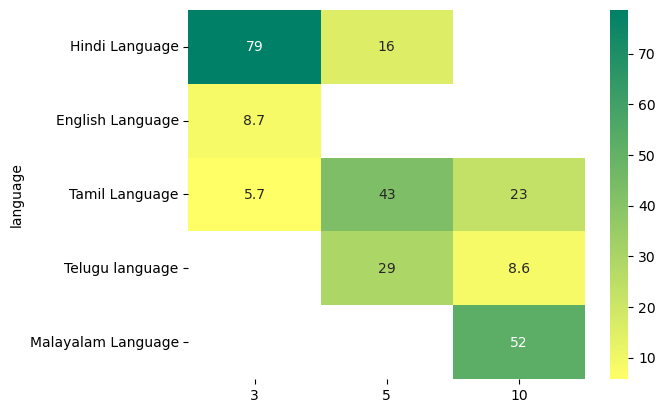

In [127]:
n = 3
first_languages = pd.DataFrame(columns=['language'])
for i in [3,5,10]:
    languages = Counter([x for y in vars()['datamov' + str(i)]['Movie_languages'].values for x in y]).most_common(n)
    print(languages)
    languages = pd.DataFrame(data=languages, columns=['language',str(i)])
    first_languages = first_languages.merge(languages,how='outer',on='language')
    normalization = len(vars()['datamov' + str(i)])
    first_languages[str(i)]= first_languages[str(i)].apply(lambda x : x/normalization*100)

first_languages.set_index(['language'],inplace = True)
plt.figure()
plot = sns.heatmap(data=first_languages,cmap = 'summer_r',annot=True)
plt.title('Movie % ')
fig = plot.get_figure()
fig.savefig("C:/Users/Public/ADA2022/weloic.github.io/_includes/india_language.png")

In [181]:
fig = px.imshow(first_languages, text_auto=True)
fig.show()

<AxesSubplot:ylabel='countrie'>

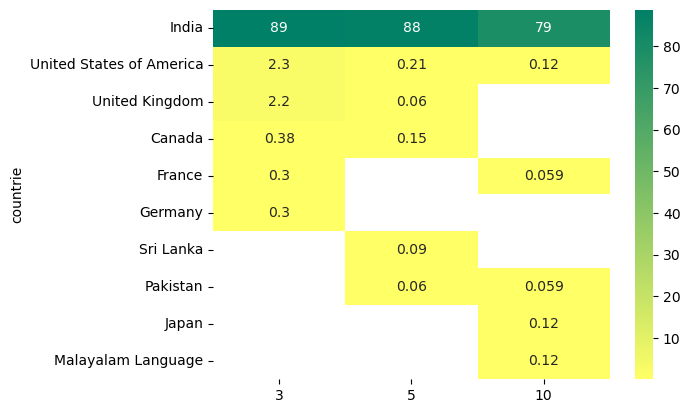

In [133]:
n = 6
first_countries = pd.DataFrame(columns=['countrie'])
for i in [3,5,10]:
    countries = Counter([x for y in vars()['datamov' + str(i)]['Movie_countries'].values for x in y]).most_common(n)
    countries = pd.DataFrame(data=countries, columns=['countrie',str(i)])
    first_countries = first_countries.merge(countries,how='outer',on='countrie')
    normalization = len(vars()['datamov' + str(i)])
    first_countries[str(i)]= first_countries[str(i)].apply(lambda x : x/normalization*100)

first_countries.set_index(['countrie'],inplace = True)
plt.figure()
sns.heatmap(data=first_countries,cmap = 'summer_r',annot=True)

In [129]:
data_actors[data_actors['Community'] == 10].head(3)

,Freebase_actor_ID,connectivity,Community,Wikidata_ID,actor_country_of_citizenship,actor_occupation,Actor_date_of_birth,actor_gender,Actor_name
4831,/m/048svj,902,10,Q6122250,India,"['actor', 'screenwriter', 'television actor', ...",1951-01-05,M,Jagathi Sreekumar
4832,/m/02fbpz,826,10,Q2050534,India,"['film actor', 'film producer', 'singer', 'pla...",1960-05-21,M,Mohanlal
4833,/m/02hkv5,776,10,Q2721855,India,"['film actor', 'film producer', 'screenwriter'...",1951-09-07,M,Mammootty


In [131]:
data_actors[data_actors['Community'] == 5].head(3)


,Freebase_actor_ID,connectivity,Community,Wikidata_ID,actor_country_of_citizenship,actor_occupation,Actor_date_of_birth,actor_gender,Actor_name
3374,/m/071wvh,1188,5,Q3765029,India,['comedian'],1956-02-01,M,Brahmanandam
3375,/m/09tqx3,845,5,Q1322453,India,"['film actor', 'film producer', 'film director...",1965-03-26,M,Prakash Raj
3376,/m/0dfjb8,679,5,Q3521977,India,"['film director', 'actor', 'screenwriter', 'fi...",1958-03-05,M,Nassar


In [132]:
data_actors[data_actors['Community'] == 3].head(3)

,Freebase_actor_ID,connectivity,Community,Wikidata_ID,actor_country_of_citizenship,actor_occupation,Actor_date_of_birth,actor_gender,Actor_name
2089,/m/04c636,1129,3,Q379604,India,"['film actor', 'politician']",1950-06-16,M,Mithun Chakraborty
2090,/m/05yvfd,969,3,Q312789,India,"['actor', 'comedian']",1958-09-03,M,Shakti Kapoor
2091,/m/0tj9,957,3,Q9570,India,"['film actor', 'film producer', 'singer', 'tel...",1942-10-11,M,Amitabh Bachchan


## Time Analysis

Text(50.722222222222214, 0.5, 'Release year')

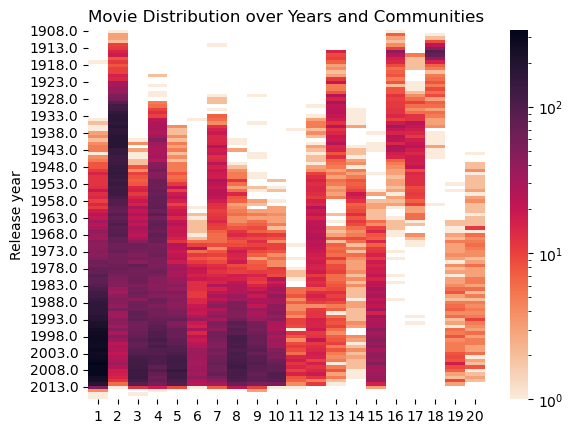

In [190]:
coms  =  np.arange(1,21)
movies_year_com = data_movies[coms.astype(str)]
movies_year_com['Movie_release_year'] = data_movies['Movie_release_year']
for y in coms.astype(str):
    movies_year_com[y] = movies_year_com[y].apply(lambda x : 1 if (x != 0) else  0)
movies_year_com = movies_year_com.groupby('Movie_release_year').agg('sum')
sns.heatmap(data=movies_year_com, norm=LogNorm(),cmap = 'rocket_r')
plt.title('Movie Distribution over Years and Communities')
plt.ylabel('Release year')

In [204]:
fig = px.imshow(np.log10(movies_year_com),y=movies_year_com.index,color_continuous_scale  = 'plasma_r',labels={'color':'log nb movies'})
fig.update_yaxes(title = 'Release year')
fig.update_xaxes(title = 'Community')
fig.update_layout(title = 'Movie Distribution over Years and Communities')
fig.show()

In [186]:
movies_year_com

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Movie_release_year,,,,,,,,,,,,,,,,,,,,
1908.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1909.0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,1,0,0
1910.0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,2,0,0
1911.0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,9,0,0
1912.0,0,10,0,0,0,0,1,0,0,0,0,0,0,0,0,4,0,22,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012.0,186,6,89,61,95,24,31,71,55,57,4,11,1,0,16,0,0,0,3,0
2013.0,48,1,12,17,9,1,7,22,10,1,1,0,0,0,3,0,0,0,0,0
2014.0,4,0,0,1,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0


### The beginning of cinema 

In [178]:
features_movies

,Unnamed: 0,Community,1st Movie_genre,1st Movie_genre %,2nd Movie_genre,2nd Movie_genre %,3rd Movie_genre,3rd Movie_genre %,4th Movie_genre,4th Movie_genre %,...,2nd Movie_country %,3rd Movie_country,3rd Movie_country %,1st Movie_language,1st Movie_language %,2nd Movie_language,2nd Movie_language %,3rd Movie_language,3rd Movie_language %,Average movie_release_year
0,0,1,Drama,0.107916,Comedy,0.085988,Thriller,0.050126,Romance Film,0.043045,...,0.091647,Germany,0.039026,English Language,0.680149,English Language,0.083711,NaN,0.039139,1995.083969
1,1,2,Drama,0.121557,Black-and-white,0.075548,Comedy,0.071913,Romance Film,0.051315,...,0.072985,Italy,0.018462,English Language,0.742041,English Language,0.073502,NaN,0.054775,1954.868108
2,2,3,Drama,0.197330,World cinema,0.131666,Romance Film,0.095665,Bollywood,0.091017,...,0.024339,United Kingdom,0.022769,Hindi Language,0.652428,English Language,0.053761,Urdu Language,0.042300,1990.780716
3,3,4,Drama,0.124247,Comedy,0.069493,Thriller,0.050982,Romance Film,0.043872,...,0.331068,France,0.037589,English Language,0.663636,English Language,0.085110,NaN,0.048746,1978.134163
4,4,5,Drama,0.260467,Romance Film,0.111209,Action,0.105333,World cinema,0.091083,...,0.002364,Canada,0.001689,Tamil Language,0.364802,Telugu language,0.247749,Hindi Language,0.141610,1993.172611
5,5,6,Chinese Movies,0.175561,World cinema,0.099111,Action,0.090640,Martial Arts Film,0.080686,...,0.164751,United States of America,0.071264,Cantonese,0.193655,Standard Mandarin,0.135417,Standard Mandarin,0.129735,1994.770721
6,6,7,Comedy,0.098847,Family Film,0.083415,Animation,0.083122,Drama,0.054112,...,0.037697,Germany,0.033140,English Language,0.737525,NaN,0.097053,English Language,0.050295,1984.993851
7,7,8,Drama,0.097243,Comedy,0.080870,Thriller,0.056134,Action,0.053866,...,0.065347,Germany,0.040170,English Language,0.644804,English Language,0.088586,Spanish Language,0.047984,1996.748561
8,8,9,Drama,0.120058,Comedy,0.059058,Thriller,0.049927,Romance Film,0.047596,...,0.290333,Germany,0.055869,English Language,0.560894,English Language,0.119926,French Language,0.050279,1997.854855
9,9,10,Drama,0.284906,Action,0.115511,Romance Film,0.086038,Comedy,0.070557,...,0.001477,Japan,0.001477,Malayalam Language,0.482892,Tamil Language,0.192605,NaN,0.144592,1997.508717


In [179]:
datamov11.sort_values(by = 'Movie_release_year')

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_languages,Movie_countries,Movie_genres,Movie_release_year,1,2,3,...,11,12,13,14,15,16,17,18,19,20
20921,32818099,/m/0h3pgbv,Manhattan Merry-Go-Round,[English Language],[United States of America],"[Comedy, Black-and-white]",1937.0,0.0,7.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7824,12145602,/m/02vr8jc,Animal Treasure Island,[Japanese Language],[Japan],"[Japanese Movies, Adventure, Animation, Anime,...",1971.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23520,1255098,/m/04mkph,Grendizer,[Japanese Language],[Japan],"[Science Fiction, Anime, Action, Romance Film,...",1975.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21675,11387538,/m/02r9t8w,Ringing Bell,[Japanese Language],[Japan],"[Japanese Movies, Family Film, Anime, Drama, A...",1978.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13149,12755223,/m/02x3fp8,Undersea Super Train: Marine Express,[],[Japan],"[Fantasy, Science Fiction, Anime, Drama]",1979.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13355,6499947,/m/0g7rbx,Doraemon The Movie 2006,[Japanese Language],[Japan],"[Anime, Japanese Movies]",NaN,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14503,33456976,/m/0h96gfh,Keroro Gunso the Super Movie: Creation! Ultima...,[],[],[Anime],NaN,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14695,7743452,/m/026blwx,Kinnikuman Movies,[Japanese Language],[],[Short Film],NaN,0.0,0.0,0.0,...,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16909,15086382,/m/03hg_55,Nobita and the Green Giant Legend 2008,[Japanese Language],[Japan],"[Anime, Japanese Movies]",NaN,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [180]:
features_movies

,Unnamed: 0,Community,1st Movie_genre,1st Movie_genre %,2nd Movie_genre,2nd Movie_genre %,3rd Movie_genre,3rd Movie_genre %,4th Movie_genre,4th Movie_genre %,...,2nd Movie_country %,3rd Movie_country,3rd Movie_country %,1st Movie_language,1st Movie_language %,2nd Movie_language,2nd Movie_language %,3rd Movie_language,3rd Movie_language %,Average movie_release_year
0,0,1,Drama,0.107916,Comedy,0.085988,Thriller,0.050126,Romance Film,0.043045,...,0.091647,Germany,0.039026,English Language,0.680149,English Language,0.083711,NaN,0.039139,1995.083969
1,1,2,Drama,0.121557,Black-and-white,0.075548,Comedy,0.071913,Romance Film,0.051315,...,0.072985,Italy,0.018462,English Language,0.742041,English Language,0.073502,NaN,0.054775,1954.868108
2,2,3,Drama,0.197330,World cinema,0.131666,Romance Film,0.095665,Bollywood,0.091017,...,0.024339,United Kingdom,0.022769,Hindi Language,0.652428,English Language,0.053761,Urdu Language,0.042300,1990.780716
3,3,4,Drama,0.124247,Comedy,0.069493,Thriller,0.050982,Romance Film,0.043872,...,0.331068,France,0.037589,English Language,0.663636,English Language,0.085110,NaN,0.048746,1978.134163
4,4,5,Drama,0.260467,Romance Film,0.111209,Action,0.105333,World cinema,0.091083,...,0.002364,Canada,0.001689,Tamil Language,0.364802,Telugu language,0.247749,Hindi Language,0.141610,1993.172611
5,5,6,Chinese Movies,0.175561,World cinema,0.099111,Action,0.090640,Martial Arts Film,0.080686,...,0.164751,United States of America,0.071264,Cantonese,0.193655,Standard Mandarin,0.135417,Standard Mandarin,0.129735,1994.770721
6,6,7,Comedy,0.098847,Family Film,0.083415,Animation,0.083122,Drama,0.054112,...,0.037697,Germany,0.033140,English Language,0.737525,NaN,0.097053,English Language,0.050295,1984.993851
7,7,8,Drama,0.097243,Comedy,0.080870,Thriller,0.056134,Action,0.053866,...,0.065347,Germany,0.040170,English Language,0.644804,English Language,0.088586,Spanish Language,0.047984,1996.748561
8,8,9,Drama,0.120058,Comedy,0.059058,Thriller,0.049927,Romance Film,0.047596,...,0.290333,Germany,0.055869,English Language,0.560894,English Language,0.119926,French Language,0.050279,1997.854855
9,9,10,Drama,0.284906,Action,0.115511,Romance Film,0.086038,Comedy,0.070557,...,0.001477,Japan,0.001477,Malayalam Language,0.482892,Tamil Language,0.192605,NaN,0.144592,1997.508717


In [171]:
alice = ['/m/03dglc','/m/0crd1h6','/m/0crf95t','/m/012brhdl','/m/03cr4q9','/m/04myvv3','/m/03yn1b0','/m/080c485','/m/0_g606b','/m/0135xbrf','/m/05c4fw0','/m/0h54mgf']
all_movies[all_movies['Freebase_movie_ID'].isin(alice)]

,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_languages,Movie_countries,Movie_genres,Movie_release_year
9291,9291,807258,/m/03dglc,La Fée aux Choux,[],[France],"[Silent film, Indie, Black-and-white, Short Fi...",1896.0
9713,9713,14019515,/m/03cr4q9,Esmeralda,[French Language],[France],"[Short Film, Silent film, Drama, Black-and-white]",1905.0
15365,15365,24463054,/m/080c485,Falling Leaves,[English Language],[United States of America],"[Short Film, Drama]",1912.0
21565,21565,28372044,/m/0crf95t,Danse serpentine,[],[France],"[Short Film, Silent film]",1896.0
42080,42080,19514976,/m/04myvv3,The Consequences of Feminism,[],[France],"[Short Film, Comedy film]",1906.0
55688,55688,16690709,/m/03yn1b0,Algie the Miner,[English Language],[United States of America],"[LGBT, Short Film, Silent film, Black-and-white]",1912.0
72614,72614,28371285,/m/0crd1h6,Le chiffonnier,[Silent film],[France],"[Short Film, Silent film]",1896.0
74675,74675,32946863,/m/0h54mgf,The Shooting of Dan McGrew,[],[],[Silent film],1915.0
77064,77064,21112004,/m/05c4fw0,Matrimony's Speed Limit,[English Language],[United States of America],"[Short Film, Silent film, Comedy, Slapstick]",1913.0


# Community 2

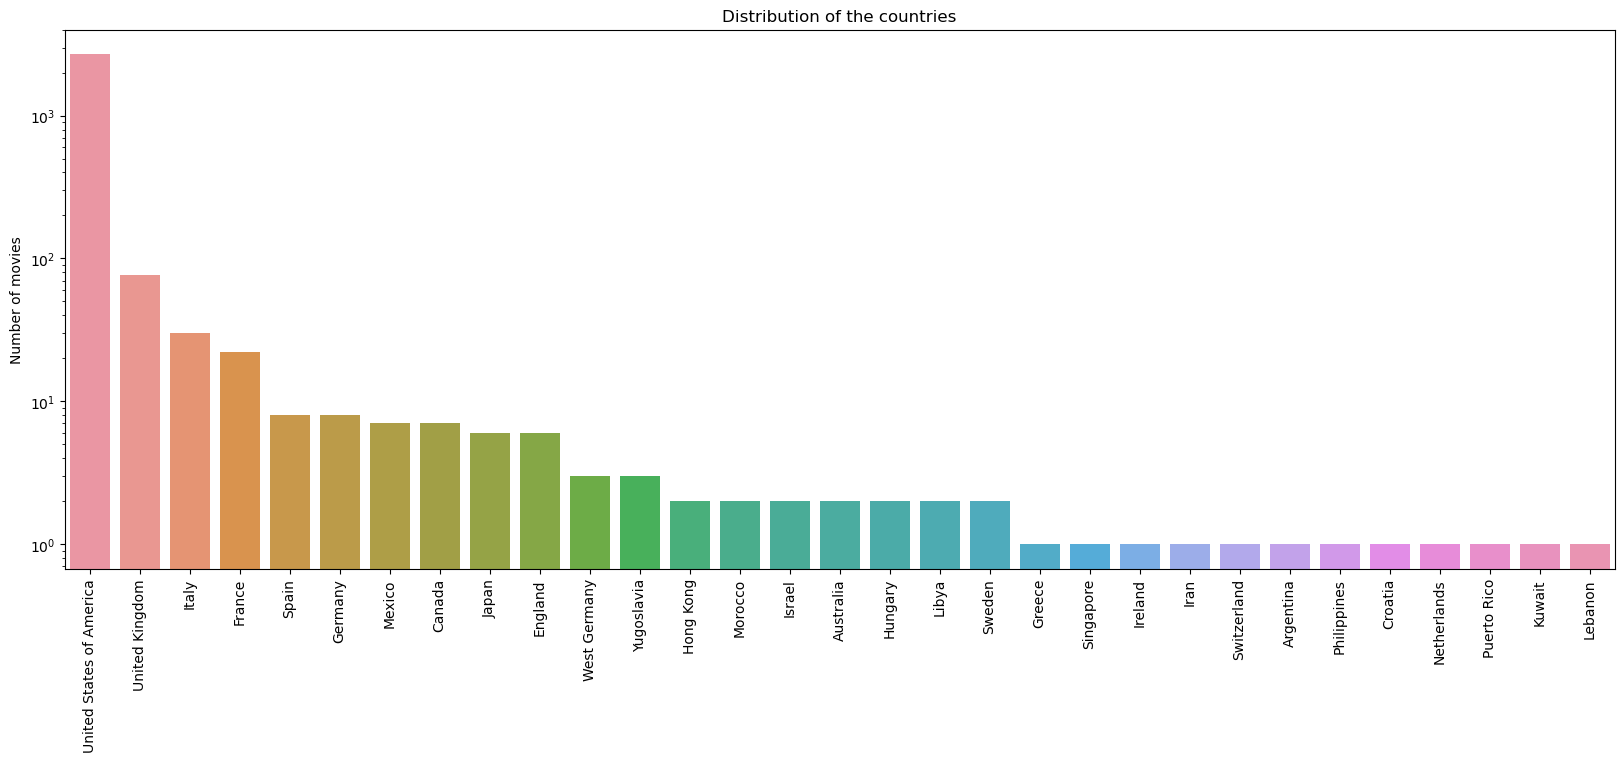

In [ ]:
plt.figure(figsize=(20,7))
plt.title('Distribution of the countries')
plt.ylabel('Number of movies')
plt.yscale('log')
sns.barplot(x=[x for x, y in Counter([x for y in data_mov2['Movie_countries'].values for x in y.values()]).most_common()], y=[
            y for x, y in Counter([x for y in data_mov2['Movie_countries'].values for x in y.values()]).most_common()])
plt.xticks(rotation=90)
plt.show()

In [ ]:
datamov2

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_genres,Movie_release_year,1,2,3,4,5,...,13,14,15,16,17,18,19,20,Movie_languages,Movie_countries
0,10408933,/m/02qc0j7,Alexander's Ragtime Band,"[Musical, Comedy, Black-and-white]",1938.0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,[English Language],[United States of America]
2,77856,/m/0kcn7,Mary Poppins,"[Childrens/Family, Musical, Fantasy, Comedy, D...",1964.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,[English Language],[United States of America]
11,10275424,/m/02q74ng,Woman Hungry,"[Musical, Western]",1930.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,[English Language],[United States of America]
14,14631844,/m/03grb4v,Joan the Woman,"[Silent film, Indie, War film, Epic, Black-and...",1917.0,0,7,0,0,0,...,0,0,0,0,0,0,0,0,"[Silent film, English Language]",[United States of America]
24,12788657,/m/02x4zpv,The Boston Strangler,"[Crime Fiction, Mystery, Thriller, Drama, Crim...",1968.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,[English Language],[United States of America]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16585,10979410,/m/02qx1v_,The Barefoot Executive,"[Family Film, Drama, Comedy]",1971.0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,[English Language],[United States of America]
16601,6740261,/m/0glmbl,Eternally Yours,"[Family Drama, Black-and-white, Drama, Comedy,...",1939.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,[English Language],[United States of America]
16602,11350779,/m/02r8kxp,Sherlock Holmes and the Voice of Terror,"[Thriller, Crime Fiction, Detective fiction, D...",1942.0,0,8,0,0,0,...,0,0,0,0,0,0,0,0,[English Language],[United States of America]
16605,22330502,/m/05sync6,Inspiration,"[Drama, Black-and-white]",1931.0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,[English Language],[United States of America]


Counter({1: 2684, 2: 80, 0: 43, 3: 16, 4: 2, 5: 1})


TypeError: cannot unpack non-iterable int object

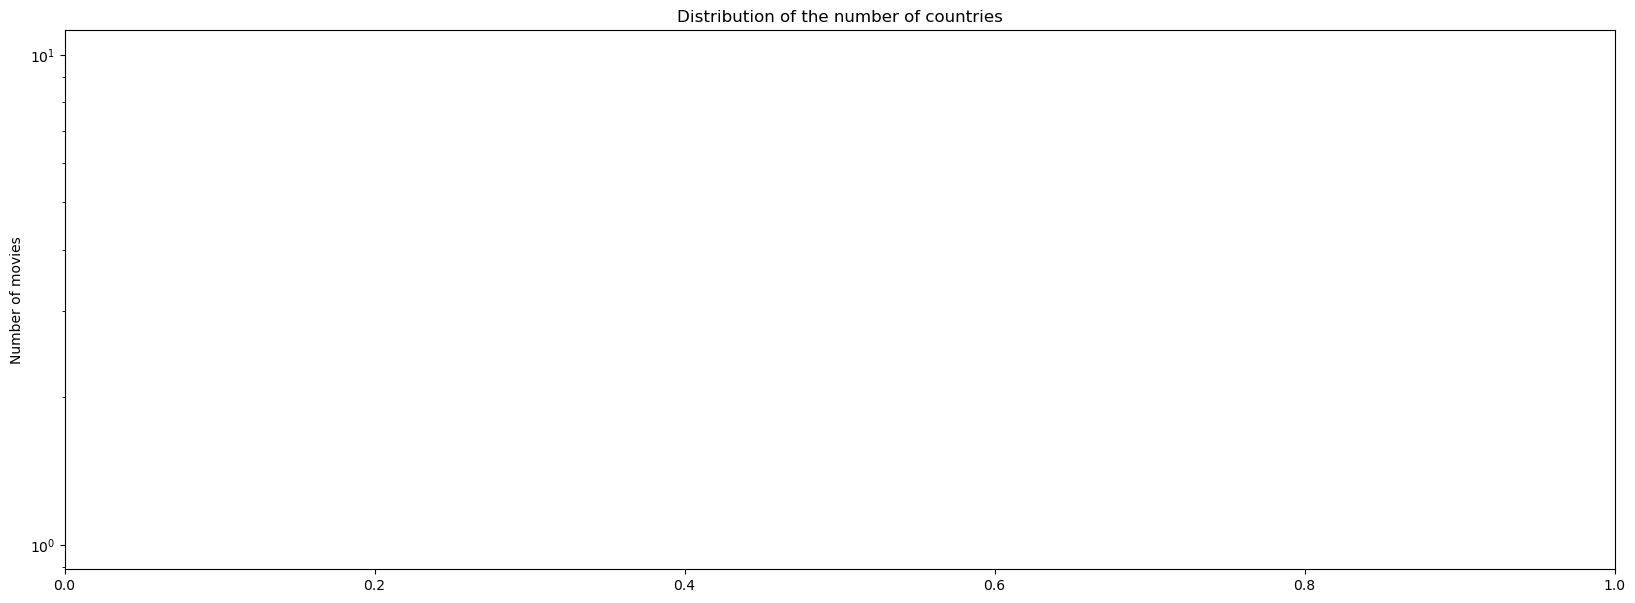

In [ ]:
#df2 = datamov2[[len(x) == 4 for x in data_mov1.Movie_countries]]
print(Counter([len(x) for x in datamov2['Movie_countries'].values]))

plt.figure(figsize=(20,7))
plt.title('Distribution of the number of countries')
plt.ylabel('Number of movies')
plt.yscale('log')
sns.barplot(x=[x for x, y in Counter([len(x) for x in datamov2['Movie_countries'].values])], y=[
            y for x, y in Counter([len(x) for x in datamov2['Movie_countries'].values])])
plt.xticks(rotation=90)
plt.show()

Way less represented nationalities (less invited people from elsewhere?)

# Community 3 

<AxesSubplot:xlabel='Movie_release_year'>

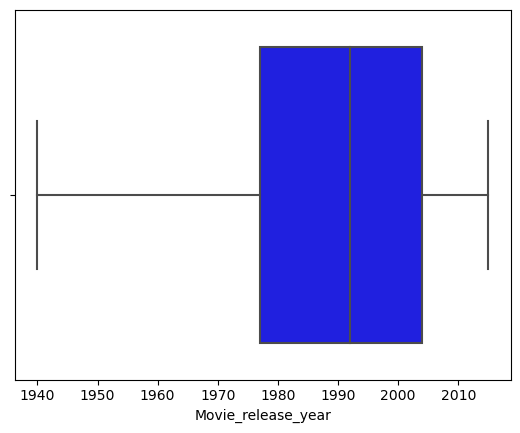

In [ ]:
sns.boxplot(data= data_mov3, x='Movie_release_year',color='blue')

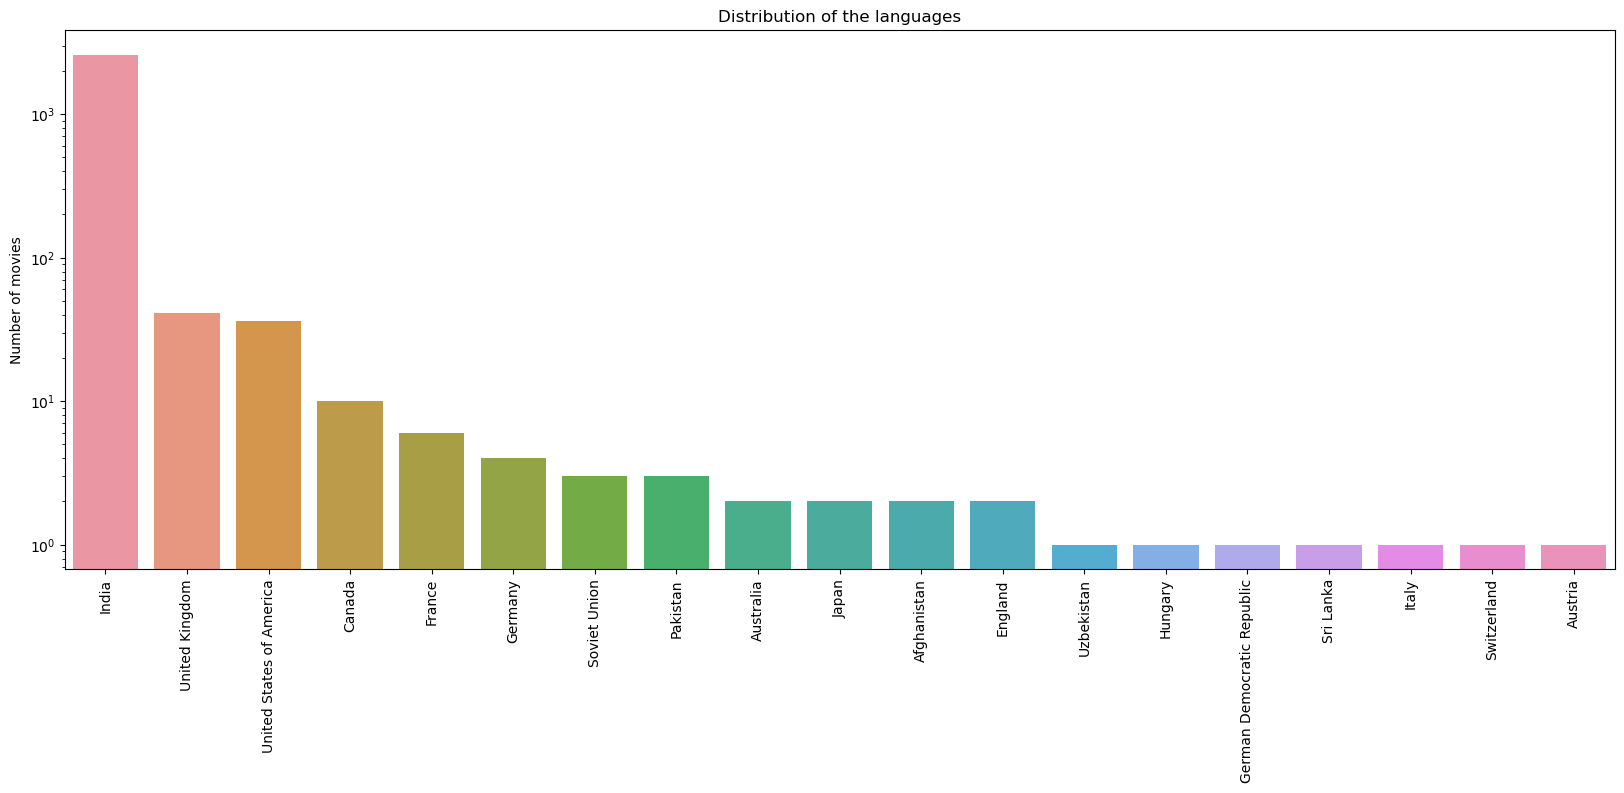

Counter({1: 2554, 0: 210, 2: 56, 3: 13, 5: 2})


In [ ]:
plt.figure(figsize=(20,7))
plt.title('Distribution of the languages')
plt.ylabel('Number of movies')
plt.yscale('log')
sns.barplot(x=[x for x, y in Counter([x for y in data_mov3['Movie_countries'].values for x in y.values()]).most_common()], y=[
            y for x, y in Counter([x for y in data_mov3['Movie_countries'].values for x in y.values()]).most_common()])
plt.xticks(rotation=90)
plt.show()

print(Counter([len(x) for x in data_mov3['Movie_countries'].values]))

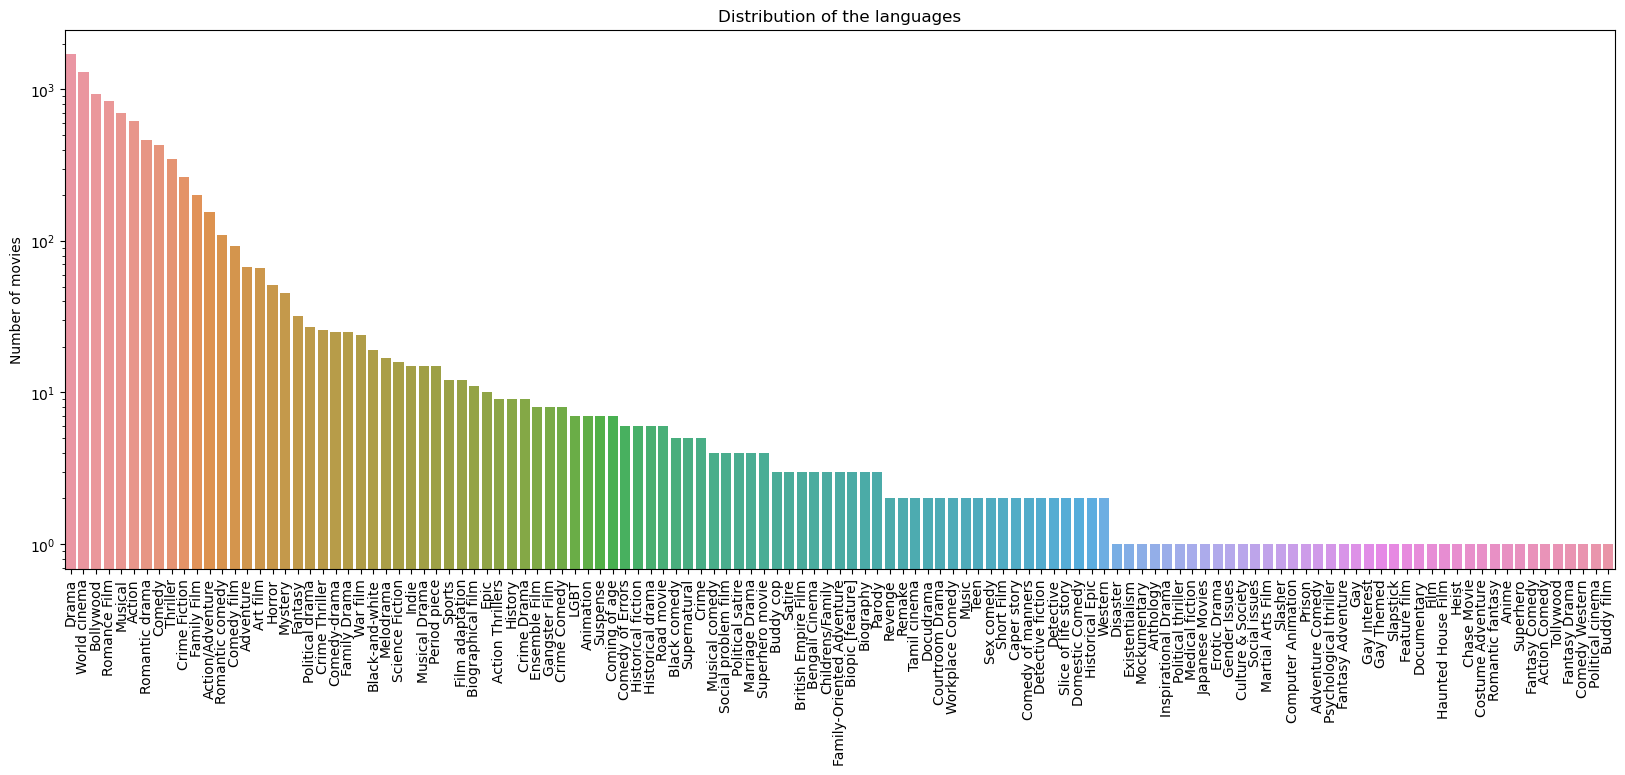

In [ ]:
plt.figure(figsize=(20,7))
plt.title('Distribution of the languages')
plt.ylabel('Number of movies')
plt.yscale('log')
sns.barplot(x=[x for x, y in Counter([x for y in data_mov3['Movie_genres'].values for x in y.values()]).most_common()], y=[
            y for x, y in Counter([x for y in data_mov3['Movie_genres'].values for x in y.values()]).most_common()])
plt.xticks(rotation=90)
plt.show()

In [ ]:
# d3 = data[data['community']==3]
# print(d3.actor_country_of_citizenship.unique())
# print(len(d3.actor_country_of_citizenship.unique()),"nationalities")
# #sns.histplot(data = d3, x = 'actor_country_of_citizenship')
# sns.barplot(x=d3['actor_country_of_citizenship'].value_counts().index, y=d3['actor_country_of_citizenship'].value_counts().values)
# ax = plt.xticks(rotation = 90)
# plt.yscale('log')

### Community 4

In [ ]:
# d4 = data[data['community']==4]
# print(d4.actor_country_of_citizenship.unique())
# print(len(d4.actor_country_of_citizenship.unique()),"nationalities")
# #sns.histplot(data = d4, x = 'actor_country_of_citizenship')
# sns.barplot(x=d4['actor_country_of_citizenship'].value_counts().index, y=d4['actor_country_of_citizenship'].value_counts().values)
# ax = plt.xticks(rotation = 90)
# plt.yscale('log')

# Genre of movies

### Genre cleaning

In [ ]:
genre_mapping = dict([
    ('Comedy film','Comedy'),
    ('test1','bulldog'),
    ('test3','pizza')
])

def genre_cleaning(tag):
    if tag in genre_mapping.keys():
        return genre_mapping[tag]
    return tag

# do the function again to remove duplicates 

In [ ]:
t= ['test1','test2','Comedy film','abc']
list(map(genre_cleaning,t))

['bulldog', 'test2', 'Comedy', 'abc']

In [ ]:
datamov11['Movie_genres'] = datamov11['Movie_genres'].apply(lambda x: list(map(genre_cleaning,x)))
             #   [k for k, v in genre_mapping.items() if x in v][0] if len([k for k, v in genre_mapping.items() if x in v]) != 0 else x)

In [ ]:
datamov11

,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_languages,Movie_countries,Movie_genres,Movie_release_year,1,2,...,11,12,13,14,15,16,17,18,19,20
109,109,2574970,/m/07p15p,Big Wars,[],[Japan],"[Science Fiction, Anime, Japanese Movies, Anim...",1993.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488,488,12169608,/m/02vs6jw,Ben 10: Secret of the Omnitrix,[English Language],[United States of America],"[Science Fiction, Childrens/Family, Fantasy, D...",2007.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
506,506,670013,/m/031f_m,Final Fantasy VII: Advent Children,[Japanese Language],[Japan],"[Thriller, Science Fiction, Japanese Movies, C...",2005.0,2.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
517,517,6773730,/m/0gn7zp,Konjiki no Gash Bell!!: 101 Banme no Mamono,[Japanese Language],[Japan],"[Anime, Japanese Movies]",2004.0,0.0,0.0,...,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
610,610,4704148,/m/0cj6db,Baron Omatsuri and the Secret Island,[Japanese Language],[Japan],"[Japanese Movies, Animation, Mystery, Anime, D...",2005.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26302,26302,4458000,/m/0c3jpx,Dream Soccer King!,[Japanese Language],[Japan],"[Short Film, Japanese Movies, Comedy, Animation]",2002.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26762,26762,25394470,/m/09g6j10,Pokémon: Zoroark: Master of Illusions,"[Japanese Language, English Language]",[],"[Action/Adventure, Thriller, Action, Fantasy]",2010.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26847,26847,30859078,/m/08dz4r,Dragon Ball Z: Bio-Broly,"[Japanese Language, English Language]",[Japan],"[Action, Anime, Japanese Movies, Science Ficti...",1994.0,0.0,0.0,...,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26907,26907,11841904,/m/02rv7tv,Seigi Choujin vs. Ancient Choujin,[Japanese Language],[Japan],"[Japanese Movies, Animation]",1985.0,0.0,0.0,...,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
Counter([x for y in datamov11['Movie_genres'].values for x in y]).most_common()

[('Animation', 182),
 ('Japanese Movies', 170),
 ('Anime', 161),
 ('Action', 101),
 ('Fantasy', 87),
 ('Science Fiction', 78),
 ('Adventure', 55),
 ('Comedy', 49),
 ('World cinema', 44),
 ('Family Film', 36),
 ('Drama', 31),
 ('Childrens', 27),
 ('Thriller', 21),
 ('Action/Adventure', 20),
 ('Animated cartoon', 17),
 ('Fantasy Adventure', 16),
 ('Romance Film', 14),
 ('Short Film', 13),
 ('Childrens/Family', 11),
 ('Martial Arts Film', 9),
 ('Computer Animation', 8),
 ('Mystery', 8),
 ('Horror', 7),
 ('Childrens Fantasy', 7),
 ('Family-Oriented Adventure', 6),
 ('Fantasy Comedy', 5),
 ('Future noir', 5),
 ('Western', 4),
 ('Sports', 4),
 ('Coming of age', 3),
 ('Crime Thriller', 3),
 ('Indie', 3),
 ('Doomsday film', 2),
 ('Psychological thriller', 2),
 ('Dystopia', 2),
 ('LGBT', 2),
 ('Parody', 2),
 ('Chinese Movies', 2),
 ('Samurai cinema', 2),
 ('Romantic comedy', 2),
 ('Black-and-white', 2),
 ('Television movie', 1),
 ('Comedy-drama', 1),
 ('Supernatural', 1),
 ('Fairy tale', 1),
 (

### main genres in each community

[('Drama', 4252), ('Comedy', 3388), ('Thriller', 1975), ('Romance Film', 1696), ('Action', 1555), ('Crime Fiction', 1425), ('Indie', 1353)]
[('Drama', 3712), ('Black-and-white', 2307), ('Comedy', 2196), ('Romance Film', 1567), ('Action', 1231), ('Action/Adventure', 1098), ('Thriller', 1090)]
[('Drama', 2335), ('World cinema', 1558), ('Romance Film', 1132), ('Bollywood', 1077), ('Action', 861), ('Musical', 858), ('Romantic drama', 574)]
[('Drama', 2866), ('Comedy', 1603), ('Thriller', 1176), ('Romance Film', 1012), ('Action', 900), ('Crime Fiction', 813), ('Adventure', 744)]
[('Drama', 1773), ('Romance Film', 757), ('Action', 717), ('World cinema', 620), ('Musical', 444), ('Comedy', 346), ('Bollywood', 338)]
[('Chinese Movies', 829), ('World cinema', 468), ('Action', 428), ('Martial Arts Film', 381), ('Action/Adventure', 358), ('Drama', 306), ('Comedy', 250)]
[('Comedy', 1012), ('Family Film', 854), ('Animation', 851), ('Drama', 554), ('Short Film', 508), ('Adventure', 386), ('Action', 

<AxesSubplot:ylabel='genre'>

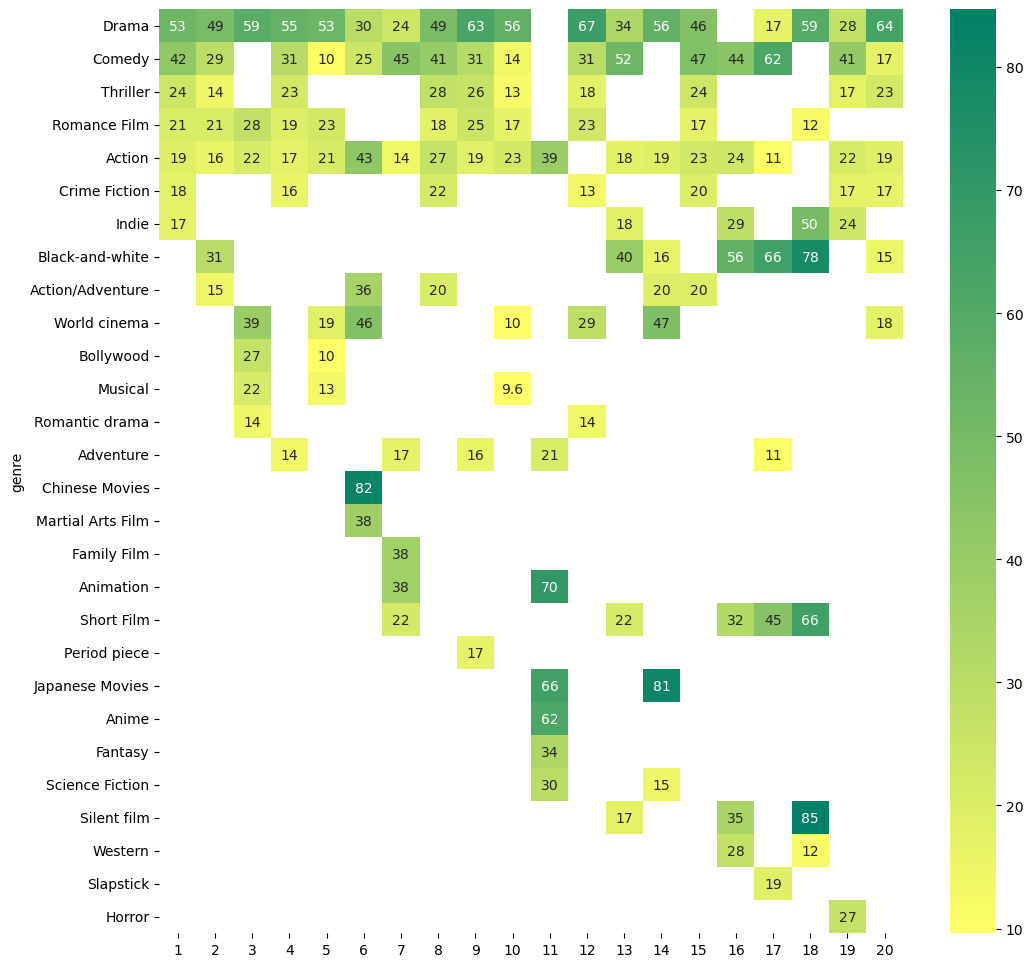

In [183]:
n = 7

first_genres = pd.DataFrame(columns=['genre'])
for i in range(1,21):
    genres = Counter([x for y in vars()['datamov' + str(i)]['Movie_genres'].values for x in y]).most_common(n)
    print(genres)
    genres = pd.DataFrame(data=genres, columns=['genre',str(i)])
    first_genres = first_genres.merge(genres,how='outer',on='genre')
    normalization = len(vars()['datamov' + str(i)])
    first_genres[str(i)]= first_genres[str(i)].apply(lambda x : x/normalization*100)

first_genres.set_index(['genre'],inplace = True)
plt.figure(figsize=(12,12))
sns.heatmap(data=first_genres,cmap = 'summer_r',annot=True)

In [ ]:
datamov18.Movie_languages.unique

<bound method Series.unique of 30                    [English Language]
41                                    []
70       [Silent film, English Language]
73                    [English Language]
149                   [English Language]
                      ...               
27131                                 []
27177    [Silent film, English Language]
27182    [Silent film, English Language]
27209                 [English Language]
27234                                 []
Name: Movie_languages, Length: 412, dtype: object>

In [ ]:
d2[(~(d2['actor_country_of_citizenship']=='India')& ~(d2['actor_country_of_citizenship']=='British Raj'))]
d2[(d2['actor_country_of_citizenship']=='France')]

,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_languages,Movie_countries,Movie_genres,Movie_release_year,1,2,...,11,12,13,14,15,16,17,18,19,20
101,101,14739568,/m/03gw63h,Hula-La-La,[English Language],[United States of America],"[Short Film, Comedy, Black-and-white, Slapstick]",1951.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0
114,114,21236198,/m/05c4c72,Thief of Damascus,[English Language],[United States of America],"[Romance Film, Fantasy, Adventure]",1952.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
174,174,44218,/m/0c1p3,San Francisco,[English Language],[United States of America],"[Disaster, Romance Film, Drama, Natural disast...",1936.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
243,243,24051028,/m/07kgp1w,No Time for Sergeants,[English Language],[United States of America],"[Slapstick, Drama, Comedy, Black-and-white, Fi...",1958.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
244,244,14734420,/m/03gvzxy,Pies and Guys,[English Language],[United States of America],"[Short Film, Comedy, Black-and-white]",1958.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27113,27113,8004497,/m/026n72t,Rhythm and Weep,[English Language],[United States of America],"[Short Film, Comedy, Black-and-white, Slapstick]",1946.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
27137,27137,3941009,/m/0b7v0f,The Man They Could Not Hang,[English Language],[United States of America],"[Horror, Black-and-white]",1939.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
27146,27146,6736424,/m/0glc67,Beer and Pretzels,[English Language],[United States of America],"[Short Film, Screwball comedy, Comedy of manne...",1933.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0
27155,27155,14738984,/m/03gw5m9,Studio Stoops,[English Language],[United States of America],"[Short Film, Comedy, Black-and-white]",1950.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0


# Community 3 

['United States of America' 'Canada' 'United Kingdom' nan 'Germany'
 'Italy' 'Honduras' 'New Zealand' 'Australia' 'Puerto Rico' 'Philippines'
 'Mexico' 'South Africa' 'Republic of Ireland']
14 nationalities


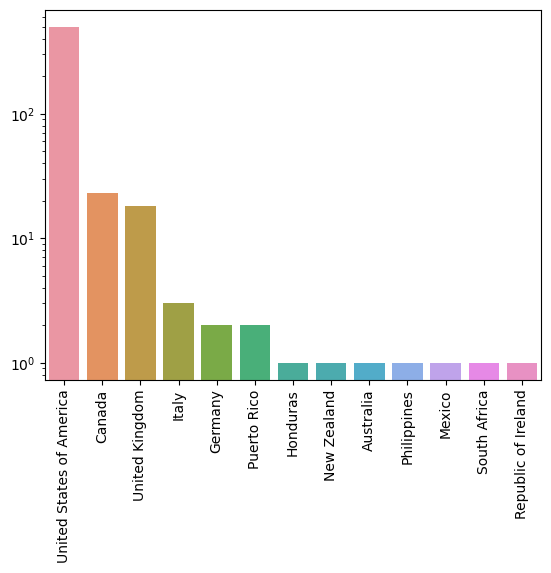

In [ ]:
d3 = data[data['community']==3]
print(d3.actor_country_of_citizenship.unique())
print(len(d3.actor_country_of_citizenship.unique()),"nationalities")
#sns.histplot(data = d3, x = 'actor_country_of_citizenship')
sns.barplot(x=d3['actor_country_of_citizenship'].value_counts().index, y=d3['actor_country_of_citizenship'].value_counts().values)
ax = plt.xticks(rotation = 90)
plt.yscale('log')

### Community 4

['United Kingdom' 'Canada' 'United States of America' 'Australia'
 'England' 'Scotland' 'New Zealand' 'Wales' 'Egypt' 'South Africa'
 'Germany' 'Republic of Ireland' 'Kingdom of the Netherlands'
 'United Kingdom of Great Britain and Ireland' 'France' nan
 "People's Republic of China" 'Italy' 'Sweden' 'Argentina' 'Norway'
 'Spain' 'Mexico' 'Pakistan' 'Poland' 'Hungary' 'Colombia' 'Lithuania'
 'Armenia' 'India' 'Austria']
31 nationalities


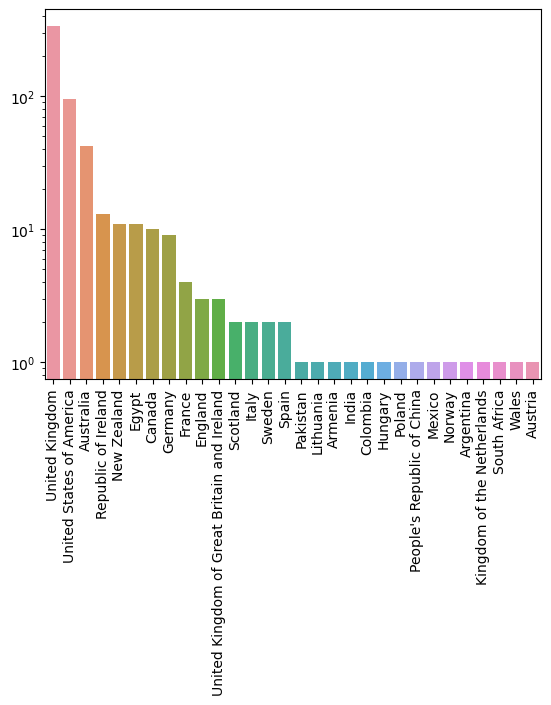

In [ ]:
d4 = data[data['community']==4]
print(d4.actor_country_of_citizenship.unique())
print(len(d4.actor_country_of_citizenship.unique()),"nationalities")
#sns.histplot(data = d4, x = 'actor_country_of_citizenship')
sns.barplot(x=d4['actor_country_of_citizenship'].value_counts().index, y=d4['actor_country_of_citizenship'].value_counts().values)
ax = plt.xticks(rotation = 90)
plt.yscale('log')
datamov17

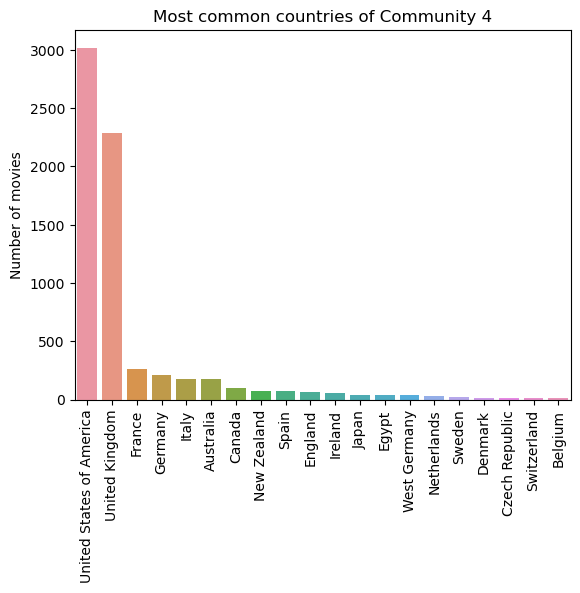

List of countries of movie production
['United States of America', 'United Kingdom', 'France', 'Germany', 'Italy', 'Australia', 'Canada', 'New Zealand', 'Spain', 'England', 'Ireland', 'Japan', 'Egypt', 'West Germany', 'Netherlands', 'Sweden', 'Denmark', 'Czech Republic', 'Switzerland', 'Belgium', 'Mexico', 'Yugoslavia', 'Norway', 'India', 'Luxembourg', 'Austria', 'Hungary', 'South Africa', 'Finland', 'Hong Kong', 'Kingdom of Great Britain', 'Poland', 'Russia', 'Argentina', 'Israel', 'Scotland', 'Romania', 'Greece', 'Iceland', 'Brazil', 'Soviet Union', 'German Democratic Republic', 'Panama', 'Croatia', 'China', 'Portugal', 'South Korea', 'Zimbabwe', 'Morocco', 'Singapore', 'Czechoslovakia', 'Iran', 'Malta', 'Lithuania', 'Crime', 'Malaysia', 'Indonesia', 'Slovakia', 'Thailand', 'Tunisia', 'Cyprus', 'Libya', 'Pakistan', 'Aruba']
List of countries


In [ ]:
#print(data_mov4.Movie_countries.unique())

# visualize the most common countries
#plt.figure(figsize=(10, 10))
plt.title('Most common countries of Community 4')
plt.ylabel('Number of movies')
sns.barplot(x=[x for x, y in Counter([x for y in datamov4['Movie_countries'].values for x in y]).most_common(
    20)], y=[y for x, y in Counter([x for y in datamov4['Movie_countries'].values for x in y]).most_common(20)])
plt.xticks(rotation=90)
plt.show()

print('List of countries of movie production')
print([x for x, y in Counter([x for y in datamov4['Movie_countries'].values for x in y]).most_common()])

print('List of countries')
#print([x for x, y in Counter([y for y in data_mov4['Movie_languages'].values]).most_common()])